In [16]:
%matplotlib inline
%load_ext jupyternotify
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import krotov
import scipy
import scipy.integrate
import plotly.graph_objects as go
import time
t1 = time.time()

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


## Description of the STIRAP class

In the below cell is the definition for <code>class STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiency_of_guess()</code>: The output returned is the efficiency for the current parameter set defining this STIRAP instance.

* <code>self.plot_for_guess(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.krotov_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses of intensity with phase and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Krotov's method](https://qucontrol.github.io/krotov/v1.2.1/07_krotovs_method.html).

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on three variables, the end time of the stokes pulse and start time of pump pulse and the two photon detuning ($\delta$).

In [60]:
class STIRAP1():
    def __init__(self,Omega_S,Omega_P,E1,E2,E3,T,tS1,tS2,tP1,tP2,Δ=0,Gamma=0,delta=0,nsteps=500):
        self.Ω_S = Omega_S
        self.Ω_P = Omega_P
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.tS1 = tS1*T
        self.tS2 = tS2*T
        self.tP1 = tP1*T
        self.tP2 = tP2*T
        self.Δ = Δ - (0.5j*Gamma)
        self.delta = delta
        self.nsteps = nsteps
    
    def _Omega_P1(self,t, args=None):
        return self.Ω_P*krotov.shapes.blackman(t, t_start=self.tP1, t_stop=self.tP2)

    def _Omega_S1(self,t, args=None):
        return self.Ω_S*krotov.shapes.blackman(t, t_start=self.tS1, t_stop=self.tS2)
    
    def _hamiltonian(self,t,i=None,j=None):
        ΔP = self.Δ #E1 + omega_P - E2
        ΔS = -ΔP + self.delta   #E3 + omega_S - E2
        H0 = np.array([[0.0, 0.0, 0.0], [0.0,ΔP, 0.0], [0.0, 0.0,self.delta]])
        HP_re = 0.5*self._Omega_P1(t)*np.array([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HS_re = 0.5*self._Omega_S1(t)*np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
        if i == None and j == None:
            return H0+HP_re+HS_re
        return (H0+HP_re+HS_re)[i,j]
    
    def _final_result(self):
        psi = np.array([1,0,0])
        tlist = np.linspace(0,self.T,self.nsteps)
        psi_list = [psi]
        dt = tlist[1]-tlist[0]
        for i in range(self.nsteps-1):
            psi = np.matmul(scipy.linalg.expm(-1j*dt*self._hamiltonian(tlist[i])),psi_list[-1])
            psi_list.append(psi)
        eff = (np.absolute(psi[2])**2)/(np.absolute(psi[0])**2 + np.absolute(psi[1])**2 + np.absolute(psi[2])**2)
        return np.array(psi_list),tlist,eff
    
    def efficiency_of_guess(self):
        psi = np.array([1,0,0])
        tlist = np.linspace(0,self.T,self.nsteps)
        dt = tlist[1]-tlist[0]
        for i in range(self.nsteps-1):
            psi = np.matmul(scipy.linalg.expm(-1j*dt*self._hamiltonian(tlist[i])),psi)
        eff = (np.absolute(psi[2])**2)/(np.absolute(psi[0])**2 + np.absolute(psi[1])**2 + np.absolute(psi[2])**2)
        return eff
    
    def _neg_eff(self,x):
        self.tS2 = x[0]*self.T
        self.tP1 = x[1]*self.T
        self.delta = x[2]/self.T
        return np.log(1-self.efficiency_of_guess())/np.log(10)
        
    def plot_for_guess(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        psiT,t,_ = self._final_result()
        fig, ax = plt.subplots()
        norm = np.absolute(psiT[:,0])**2 + np.absolute(psiT[:,1])**2 + np.absolute(psiT[:,2])**2
        ax.plot(t, np.absolute(psiT[:,0])**2/norm, label='1')
        ax.plot(t, np.absolute(psiT[:,1])**2/norm, label='2')
        ax.plot(t, np.absolute(psiT[:,2])**2/norm, label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        pulse = tlist
        if callable(self._Omega_P1) and callable(self._Omega_S1):
            pulse1 = np.array([self._Omega_P1(t, args=None) for t in tlist])
            pulse2 = np.array([self._Omega_S1(t, args=None) for t in tlist])
        plt.plot(tlist, pulse1,label="Pump")
        plt.plot(tlist, pulse2,label="Stokes")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def scipy_opti_result(self,print_pulse=True,print_results=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.array([self.tS2,self.tP1,self.delta*self.T]), args=(), method='Powell', #bounds = [(0.1,1),(0,0.9),(-40,40)],
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10, 'disp': True})
        if print_results:
            print(opti)
        self.tS2 = opti.x[0]*self.T
        self.tP1 = opti.x[1]*self.T
        if print_pulse:
            self.plot_for_guess()
            
    def robustness(self,error=0.01):
        run = STIRAP1(Omega_S=self.Ω_S,Omega_P=self.Ω_P,E1=self.E1,E2=self.E2,E3=self.E3,T=self.T,tS1=self.tS1/self.T,tS2=self.tS2/self.T,
                      tP1=self.tP1/self.T,tP2=self.tP2/self.T,Δ=self.Δ.real,Gamma=-2*self.Δ.imag,delta=self.delta,nsteps=self.nsteps)
        deff = [1,1,1,1,1]
        run.Ω_S = (1 + error)*self.Ω_S
        plus = run.efficiency_of_guess()
        run.Ω_S = (1 - error)*self.Ω_S
        minus = run.efficiency_of_guess()
        deff[0] = (plus - minus)/(2*error)
        run.Ω_S = self.Ω_S
        ################################
        run.Ω_P = (1 + error)*self.Ω_P
        plus = run.efficiency_of_guess()
        run.Ω_P = (1 - error)*self.Ω_P
        minus = run.efficiency_of_guess()
        deff[1] = (plus - minus)/(2*error)
        run.Ω_P = self.Ω_P
        ################################
        run.Δ = (1 + error)*self.Δ.real + self.Δ.imag
        plus = run.efficiency_of_guess()
        run.Δ = (1 - error)*self.Δ.real + self.Δ.imag
        minus = run.efficiency_of_guess()
        deff[2] = (plus - minus)/(2*error)
        run.Δ = self.Δ
        ################################
        run.delta = (1 + error)*self.delta
        plus = run.efficiency_of_guess()
        run.delta = (1 - error)*self.delta
        minus = run.efficiency_of_guess()
        deff[3] = (plus - minus)/(2*error)
        run.delta = self.delta
        ################################
        run.T = (1 + error)*self.T
        plus = run.efficiency_of_guess()
        run.delta = (1 - error)*self.T
        minus = run.efficiency_of_guess()
        deff[4] = (plus - minus)/(2*error)
        run.delta = self.delta
        ################################
        robust = (deff[0]**2 + deff[1]**2 + deff[2]**2 + deff[3]**2 + deff[4]**2)**0.5
        return robust

In [3]:
class cavity_STIRAP():
    def __init__(self,Omega_T,g,E1,E2,E3,T,t0,t1,Δ1=0,gamma=0,Δ2=0,kappa=0,nsteps=500):
        self.Ω_T = Omega_T
        self.g = g
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.t0 = t0*T
        self.t1 = t1*T
        self.kappa = kappa
        self.Δ1 = Δ1 - 0.5j*gamma
        self.Δ2 = Δ2
        self.nsteps = nsteps
    
    def _Omega_T(self,t,args):
        return self.Ω_T*krotov.shapes.blackman(t, t_start=self.t0, t_stop=self.t1)
    
    def _g(self,t,args):
        return self.g
    
    def _hamiltonian(self):
        H0 = tensor(Qobj([[0.0, 0.0, 0.0], [0.0,self.Δ1, 0.0], [0.0, 0.0,self.Δ2]]),qeye(4)) 
        HP_re = tensor(Qobj([[0.0, 0.5, 0.0], [0.5, 0.0, 0.0], [0.0, 0.0, 0.0]]),qeye(4))
        HS_re = tensor(Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0]]),create(4)) + tensor(Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]),destroy(4))
        return [H0,[HP_re, self._Omega_T],[HS_re, self._g]]
    
    def _final_result(self):
        psi0 = tensor(fock(3,0),fock(4,0))
        kets = [Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        a = tensor(qeye(3),destroy(4))
        e_op_list = [tensor(ket2dm(ket),qeye(4)) for ket in kets] + [a.dag() * a]
        tlist = np.linspace(0,self.T,self.nsteps)
        H = self._hamiltonian()
        c_op_list = [np.sqrt(self.kappa)*a]
        output = mesolve(H, psi0, tlist, c_op_list, e_op_list)
        eff = output.expect[2][-1]
        return output,eff
    
    def efficiency_of_guess(self):
        return self._final_result[1]
    
    def _neg_eff(self,x):
        self.tS2 = x[0]*self.T
        self.tP1 = x[1]*self.T
        self.delta = x[2]/self.T
        return -1*self.efficiency_of_guess()
        
    def plot_for_guess(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        result,_ = self._final_result()
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.plot(result.times, result.expect[3], label='photon')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        pulse = tlist
        if callable(self._Omega_T) and callable(self._g):
            pulse1 = np.array([self._Omega_T(t,args=None) for t in tlist])
            pulse2 = np.array([2*self._g(t,args=None) for t in tlist])
        plt.plot(tlist, pulse1,label="$\Omega_T(t)$")
        plt.plot(tlist, pulse2,label="2g(t)")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
#     def scipy_opti_result(self,print_pulse=True,print_results=True):
#         opti = scipy.optimize.minimize(self._neg_eff, x0=np.array([self.tS2,self.tP1,self.delta*self.T]), args=(), method='Powell', #bounds = [(0.1,1),(0,0.9),(-40,40)],
#                                        options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10, 'disp': True})
#         if print_results:
#             print(opti)
#         self.tS2 = opti.x[0]*self.T
#         self.tP1 = opti.x[1]*self.T
#         if print_pulse:
#             self.plot_for_guess()

### Example 1
Below is the simulation with both pulses having peak of 31.6 MHz and full overlap over a width of 20 $\mu s$. The single photon detuning is $\Delta = 1$ GHz and there is two photon resonance.

Efficiency = 0.9974487356102066


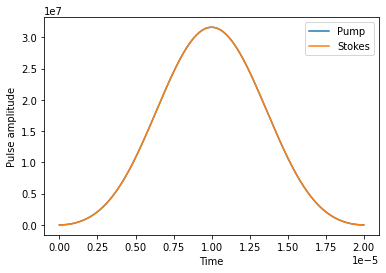

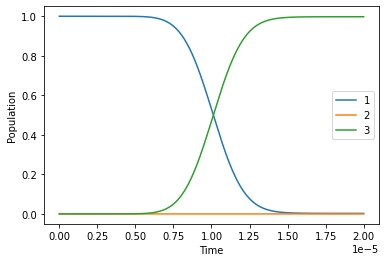

0.26507521951673385


In [61]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
try_1 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=20*10**(-6),tS1=0,tS2=1,tP1=0,tP2=1,Δ=1*10**9)
print("Efficiency = "+str(try_1.efficiency_of_guess()))
try_1.plot_for_guess()
print(try_1.robustness())

Optimization terminated successfully.
         Current function value: -2.292514
         Iterations: 5
         Function evaluations: 199
   direc: array([[ 8.91443902e-02,  1.16541442e-01,  1.01390542e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 7.97145026e-04, -1.63064376e-05,  3.50379341e-03]])
     fun: -2.2925138580734843
 message: 'Optimization terminated successfully.'
    nfev: 199
     nit: 5
  status: 0
 success: True
       x: array([ 1.21424479,  0.17169628, 54.65548381])


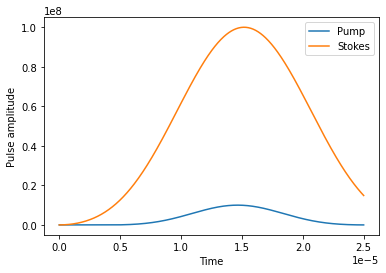

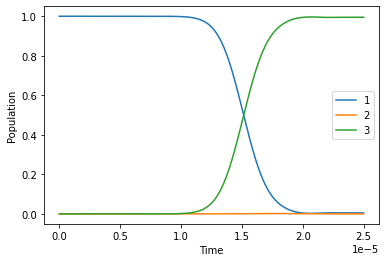

Efficiency = 0.994900986733325


In [6]:
try_2 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=2.5*10**(-5),tS1=0,tS2=0.8,tP1=0.14,tP2=1,Δ=10**9,delta=2.088*10**6)
try_2.scipy_opti_result()
print("Efficiency = "+str(try_2.efficiency_of_guess()))

Efficiency = 0.9114136073820122


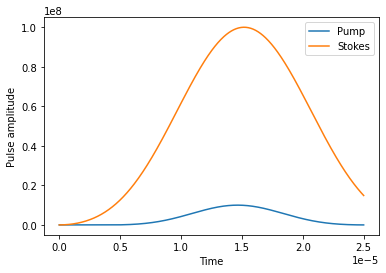

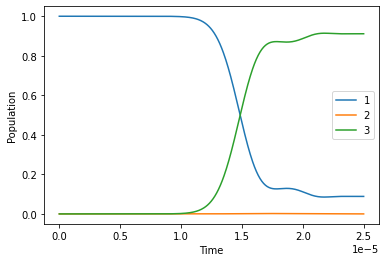

In [26]:
try_2 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=2.5*10**(-5),tS1=0,tS2=1.21424479,tP1=0.17169628,tP2=1,Δ=0.95*10**9,delta=2.18*10**6)
print("Efficiency = "+str(try_2.efficiency_of_guess()))
try_2.plot_for_guess()

In [34]:
points = 100
x_range = np.linspace(0.8,1.5,points)
y_range = np.linspace(0.1,0.6,points)
X,Y = np.meshgrid(x_range, y_range)
Z = [[-1 for i in range(points)] for j in range(points)]
for i in range(len(Y)):
    for j in range(len(X)):
        try_4 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=x_range[j],tP1=y_range[i],tP2=1,Δ=10**9,delta=2182237.5052)
        Z[i][j] = try_4.efficiency_of_guess()
    print("Progress\t"+str(i)+"/"+str(points)+"\t Last: "+str(Z[i][j]))
Z = np.array(Z)

Progress	0/100	 Last: 0.6526870325292974
Progress	1/100	 Last: 0.6605363373650132
Progress	2/100	 Last: 0.6683961024710232
Progress	3/100	 Last: 0.6762624408752255
Progress	4/100	 Last: 0.6841312806642497
Progress	5/100	 Last: 0.6919983446891035
Progress	6/100	 Last: 0.6998591302068803
Progress	7/100	 Last: 0.7077088885101429
Progress	8/100	 Last: 0.7155426079521794
Progress	9/100	 Last: 0.723355000632098
Progress	10/100	 Last: 0.7311404972763451
Progress	11/100	 Last: 0.738893246529851
Progress	12/100	 Last: 0.7466071266653472
Progress	13/100	 Last: 0.7542757586743278
Progress	14/100	 Last: 0.7618925325653915
Progress	15/100	 Last: 0.7694506298515289
Progress	16/100	 Last: 0.7769430544958182
Progress	17/100	 Last: 0.7843626558645197
Progress	18/100	 Last: 0.7917021501256379
Progress	19/100	 Last: 0.7989541333493316
Progress	20/100	 Last: 0.8061110810306519
Progress	21/100	 Last: 0.813165343735739
Progress	22/100	 Last: 0.8201091203292493
Progress	23/100	 Last: 0.8269344348711019
Progr

In [35]:
np.save("eff_better.npy",Z)

In [62]:
times = np.linspace(1,100,20)
effi_T = []
robusts = []
for T in times:
    print("============================"+str(T)+"=========================")
    try_5 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=T*10**(-6),tS1=0,tS2=0.9,tP1=0.4,tP2=1,Δ=10**9,delta=2*10**6)
    try_5.scipy_opti_result(False)
    effi_T.append(try_5.efficiency_of_guess())
    robusts.append(try_5.robustness())

============================1.0=========================
Optimization terminated successfully.
         Current function value: -0.002665
         Iterations: 4
         Function evaluations: 153
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.51522439e-02,  7.32934510e-04,  3.86689747e-03],
       [-4.25609216e-03, -6.30770353e-03, -1.22842833e-02]])
     fun: -0.0026645662581951273
 message: 'Optimization terminated successfully.'
    nfev: 153
     nit: 4
  status: 0
 success: True
       x: array([ 1.06301135, -0.06254808,  1.80531851])
============================6.2105263157894735=========================
Optimization terminated successfully.
         Current function value: -0.098668
         Iterations: 4
         Function evaluations: 147
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.85873428e-03, -1.69469900e-07,  2.34035510e-03],
       [-1.14739549e-02, -1.27743128e-02,  4.52395490e-03]])
     fun: -0.09866

============================79.1578947368421=========================
   direc: array([[-8.37780389e-02, -1.13961721e-01, -1.97490842e+00],
       [ 5.79810712e-04,  3.42277247e-05, -5.18145046e-03],
       [-4.52070363e-03, -5.30924780e-03, -1.50784241e-01]])
     fun: -4.163637162658827
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 416
     nit: 10
  status: 2
 success: False
       x: array([  1.23327924,  -0.2239047 , 150.93905445])
============================84.36842105263158=========================
Optimization terminated successfully.
         Current function value: -3.281383
         Iterations: 8
         Function evaluations: 318
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-3.23137492e-03, -6.57522255e-03, -1.31080848e-01],
       [-9.20919598e-04, -6.32767975e-04,  1.27409574e-03]])
     fun: -3.281383196297472
 message: 'Optimization terminated successfully.'
    nfev: 318
     nit: 8
  status: 0
 success: True
  

Text(0, 0.5, '$-\\log_{10} (1-$efficiency)')

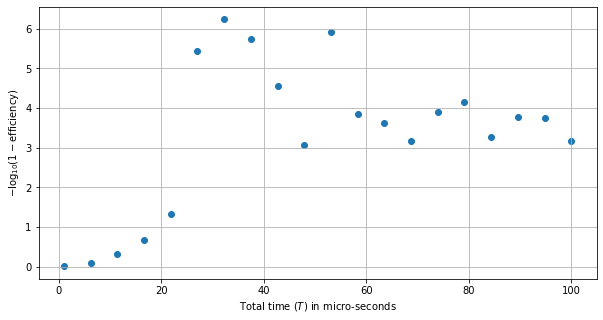

In [63]:
effi_T = np.array(effi_T)
def eff_interpolated(x,V,C):
    x_points = V
    y_points = C
    tck = scipy.interpolate.splrep(x_points, y_points)
    return scipy.interpolate.splev(x, tck)
x_times = np.linspace(1,100,1000)
logs = eff_interpolated(x_times,times,-np.log(1-effi_T)/np.log(10))


fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
# %matplotlib inline
ax.scatter(times,-np.log(1-effi_T)/np.log(10))
# ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('$-\log_{10} (1-$efficiency)')

Text(0, 0.5, 'Robustness')

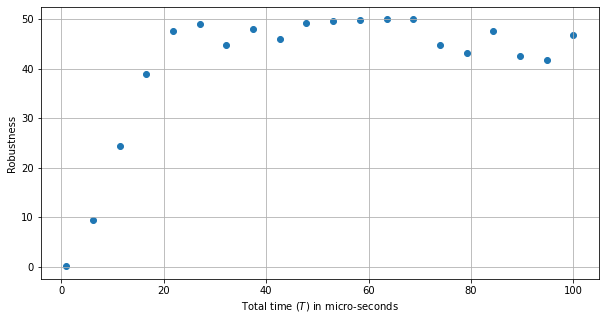

In [65]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
# %matplotlib inline
ax.scatter(times,robusts)
# ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('Robustness')

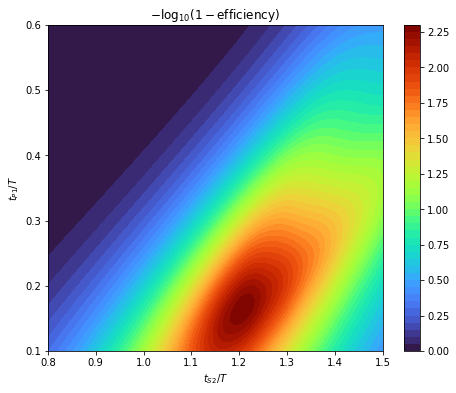

In [37]:
Z1 = np.load("eff_better.npy")
sh_0, sh_1 = Z1.shape
X1, Y1 = np.linspace(0.8, 1.5, sh_0), np.linspace(0.1, 0.6, sh_1)
plt.gcf().set_size_inches(7.5,6)
plt.xlabel("$t_{S2}/T$")
plt.ylabel("$t_{P1}/T$")
plt.title("$-\log_{10}(1-$efficiency$)$")
plt.contourf(X1, Y1, -np.log(1-Z1)/np.log(10), 50, cmap='turbo')
plt.colorbar();
# fig = go.Figure(data=[go.Surface(z=Z1, x=X1, y=Y1)])
# fig.update_layout(title='Variation of efficiencies',#autosize=False,
#                   width=1000, height=700,
#                   margin=dict(l=65, r=50, b=65, t=90)
#                  )
# fig.show()

In [67]:
times = np.linspace(1,100,20)
effi_T0 = []
robusts0 = []
for T in times:
    print("============================"+str(T)+"=========================")
    try_5 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=T*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**9,delta=0)
    try_5.scipy_opti_result(False)
    effi_T0.append(try_5.efficiency_of_guess())
    robusts0.append(try_5.robustness())

============================1.0=========================
Optimization terminated successfully.
         Current function value: -0.002666
         Iterations: 4
         Function evaluations: 175
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.62167859e-02,  7.90385565e-04, -9.20594874e-04],
       [-4.05598904e-03, -6.03149386e-03, -2.43280956e-03]])
     fun: -0.0026657202358179393
 message: 'Optimization terminated successfully.'
    nfev: 175
     nit: 4
  status: 0
 success: True
       x: array([ 1.06319057, -0.06311538,  0.03150405])
============================6.2105263157894735=========================
Optimization terminated successfully.
         Current function value: -0.106949
         Iterations: 4
         Function evaluations: 154
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.56752337e-02,  7.61059984e-04, -8.52871395e-04],
       [-4.19058329e-03, -6.18468773e-03, -1.04999241e-02]])
     fun: -0.10694

============================84.36842105263158=========================
Optimization terminated successfully.
         Current function value: -3.630967
         Iterations: 4
         Function evaluations: 165
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-4.94455698e-04,  5.99871580e-06,  2.01382147e-03]])
     fun: -3.630967231094682
 message: 'Optimization terminated successfully.'
    nfev: 165
     nit: 4
  status: 0
 success: True
       x: array([ 1.72930397, -0.13880542,  2.1882748 ])
============================89.57894736842105=========================
Optimization terminated successfully.
         Current function value: -3.728573
         Iterations: 8
         Function evaluations: 328
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.42866230e-03, -1.34538430e-04,  3.62770984e-03],
       [-1.35928495e-02, -1.02716664e-02,  1.65750707e-02]])
     fun:

In [68]:
t2 = time.time()
print(t2-t1)
%notify -m "Check the notebook"

14675.955718040466


<IPython.core.display.Javascript object>

Text(0, 0.5, 'Robustness')

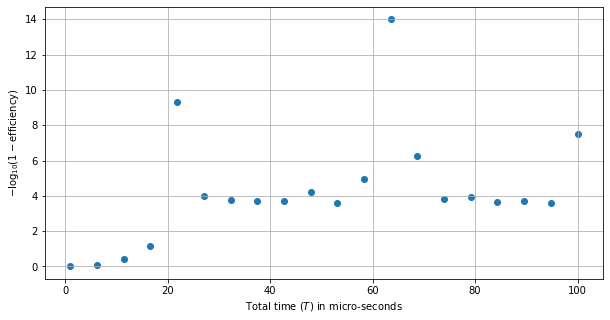

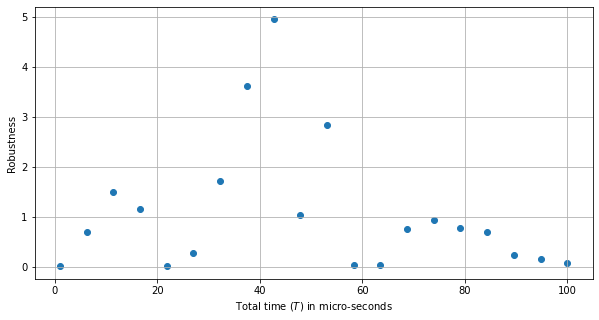

In [70]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
# %matplotlib inline
ax.scatter(times,-np.log(1-np.array(effi_T0))/np.log(10))
# ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('$-\log_{10} (1-$efficiency)')
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
# %matplotlib inline
ax.scatter(times,robusts0)
# ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('Robustness')

0.9947034893748468


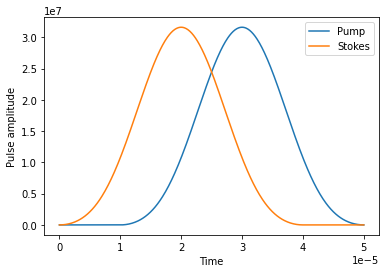

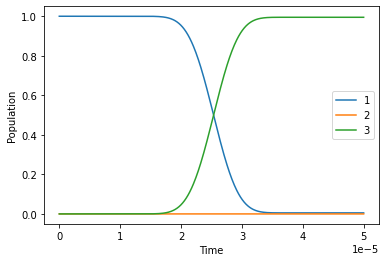

0.2461510389744988


In [82]:
try_6 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=50*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**9,delta=0)
# try_6.scipy_opti_result(True)
print(try_6.efficiency_of_guess())
try_6.plot_for_guess()
print(try_6.robustness())

0.9994726602230813


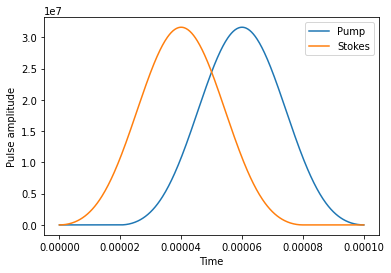

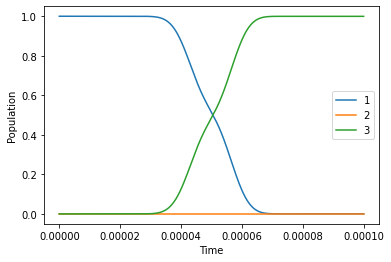

0.07577478120701191


In [86]:
try_7 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=100*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**9,delta=0)
# try_6.scipy_opti_result(True)
print(try_7.efficiency_of_guess())
try_7.plot_for_guess()
print(try_7.robustness())

0.9999999002450578


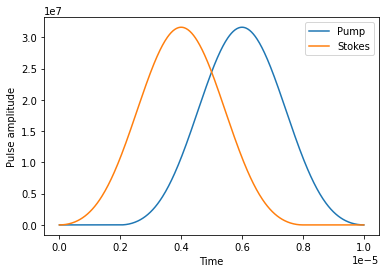

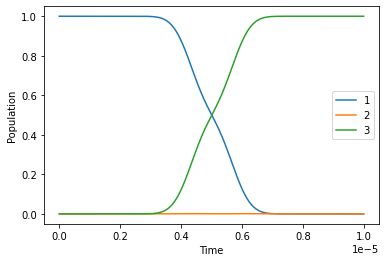

0.0009067205073409492


In [88]:
try_7 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=10*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**8,delta=0)
# try_6.scipy_opti_result(True)
print(try_7.efficiency_of_guess())
try_7.plot_for_guess()
print(try_7.robustness())

0.3058324707655031


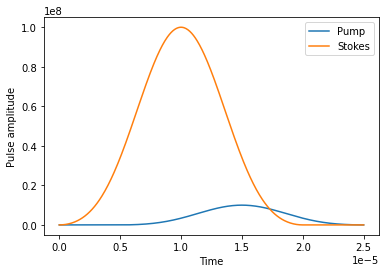

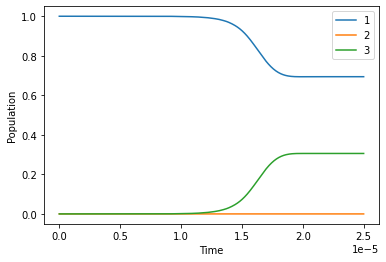

0.5863482366501136


In [94]:
try_8 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**8,delta=0)
# try_8.scipy_opti_result(True)
print(try_8.efficiency_of_guess())
try_8.plot_for_guess()
print(try_8.robustness())

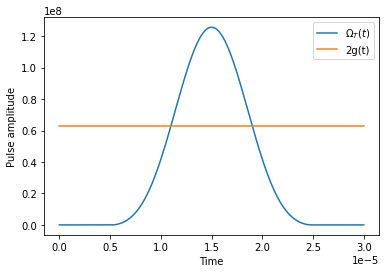

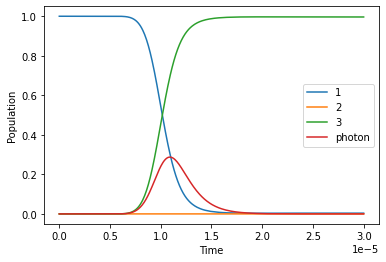

In [22]:
cavity1 = cavity_STIRAP(Omega_T = 2*np.pi*20*(10**6),g = 2*np.pi*5*(10**6),E1=0,E2=hfs,E3=F_3,T=3*(10**(-5)),t0=0.17,t1=0.83,Δ1=0,gamma=0,Δ2=0,kappa=np.pi*.25*(10**6),nsteps=500)
cavity1.plot_for_guess()